Notebook for Optim application. Notebook for supplementary material of a submitted publication. 

### Imports and settings

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json


%matplotlib widget
import time
import numpy as np
from aeromaps import create_process
from aeromaps.core.models import (
    models_optim_simple,
)

import gemseo as gm
gm.configure_logger()

<RootLogger root (INFO)>

# 1- Scenario initialisation and settings

The first phase corresponds to running a first, central scenario with AeroMAPS. Other runs ar performed afterwards.

In [2]:
from aeromaps.utils.functions import create_partitioning

In [3]:
create_partitioning(file="data_optim/aeroscope_europe_data.csv", path="data_optim")

## 2. Run AeroMAPS on this studied scope

In [4]:
%matplotlib widget
from aeromaps import create_process
from aeromaps.core.models import default_models_top_down

In [5]:
models = {
    "models_optim_simple": models_optim_simple,
}

Create process as usual, the partitionning is recuperated as specified in the config file.

In [6]:
process = create_process(
    configuration_file="data_optim/config.json",
    models=models,
    use_fleet_model=False
)

## 1-a) Air traffic evolution

As of April 2024, AeroMAPS is considering an exgenous growth rate.
For the purposes of this article, an uniform growth rate of 3% is set. This is significantly lower from industry prospects such as [Airbus GMF: 3.6%](https://www.airbus.com/en/products-services/commercial-aircraft/market/global-market-forecast) or [Boeing CMO: 3.8%](https://www.boeing.com/content/dam/boeing/boeingdotcom/market/assets/downloads/CMO_2022_Report_FINAL_v02.pdf), but higher than [IEA Net Zero: 2.1% (2019 as base year)](https://www.iea.org/reports/net-zero-roadmap-a-global-pathway-to-keep-the-15-0c-goal-in-reach).


In [7]:
## Growth rate by category [%]
process.parameters.cagr_passenger_short_range_reference_periods = []
process.parameters.cagr_passenger_short_range_reference_periods_values = [1.0]
process.parameters.cagr_passenger_medium_range_reference_periods = []
process.parameters.cagr_passenger_medium_range_reference_periods_values = [1.0]
process.parameters.cagr_passenger_long_range_reference_periods = []
process.parameters.cagr_passenger_long_range_reference_periods_values = [1.0]
process.parameters.cagr_freight_reference_periods = []
process.parameters.cagr_freight_reference_periods_values = [1.0]

## 1-b) Aircraft fleet

Top-down fleet, without hydrogen aircraft, callibrated on the fleet of the MACC applciation, with drop-in instead of h2  
http://localhost:8888/lab/tree/aeromaps/notebooks/data_cost/top_down_cost_callibration_phd.ipynb

Mean annual efficiency improvement: 1.4% --> applied to all catgeories

In [8]:
process.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years_values = [1.4]
process.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years_values = [1.4]
process.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years_values = [1.4]

## Hydrogen aircraft
# NONE

### 1-c) Operational improvements

Operational improvements are considered via two opportunities. 
- Load factor improvement: improvement to 89% at the end of the scenario.
- Operational efficiency (better ATM, aircrfat MRO and operational optimisation): improvement of 8% in 25y. 

Cost savings incur through the fuel savings. However, it could come at an extra cost (non-energy). This parameter is modelled, but not considered in this article due to lack of specific informations to the best of our knowldege.


In [9]:
process.parameters.load_factor_end_year = 89.0  # 2019 value: 82.399312

In [10]:
# Aircraft fleet and operation evolution - Operations

## Values for setting the logistic function
process.parameters.operations_final_gain = 8.0  # [%]
process.parameters.operations_start_year = 2025
process.parameters.operations_duration = 25.0

## 1-d) Energy

Top-down callibrated on the values of teh MACC apllication.
Faster optim but caution as MFSP full computation is more detailled: larges use of e-fuel in the begining influence late mFSp (no-decomissioning)

In [11]:
# # Energy settings: production choices

# # Aircraft energy - Introduction of alternative drop-in fuels

# ## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
process.parameters.biofuel_share_reference_years = [2030, 2035, 2040, 2045, 2050]
# process.parameters.biofuel_share_reference_years_values = [0, 2, 4.8, 15, 24, 27, 35]
process.parameters.electrofuel_share_reference_years = [2030, 2035, 2040, 2045, 2050]
# process.parameters.electrofuel_share_reference_years_values = [0, 0, 1.2, 5, 10, 15, 35]


## Share of biofuel production pathways (the rest being completed by AtJ processes) [%]
process.parameters.biofuel_hefa_fog_share_reference_years = []
process.parameters.biofuel_hefa_fog_share_reference_years_values = [0.6]
process.parameters.biofuel_hefa_others_share_reference_years = []
process.parameters.biofuel_hefa_others_share_reference_years_values = [12.5]
process.parameters.biofuel_ft_others_share_reference_years = []
process.parameters.biofuel_ft_others_share_reference_years_values = [68.9]
process.parameters.biofuel_ft_msw_share_reference_years = []
process.parameters.biofuel_ft_msw_share_reference_years_values = [6.6]


In [12]:
process.parameters.biofuel_hefa_fog_mfsp_simple_reference_years = []
process.parameters.biofuel_hefa_fog_mfsp_simple_reference_years_values = [0.815488]
process.parameters.biofuel_hefa_others_mfsp_simple_reference_years = []
process.parameters.biofuel_hefa_others_mfsp_simple_reference_years_values = [1.052703]
process.parameters.biofuel_ft_others_mfsp_simple_reference_years = []
process.parameters.biofuel_ft_others_mfsp_simple_reference_years_values = [1.378082]
process.parameters.biofuel_ft_msw_mfsp_simple_reference_years = []
process.parameters.biofuel_ft_msw_mfsp_simple_reference_years_values = [1.142423]
process.parameters.biofuel_atj_mfsp_simple_reference_years = []
process.parameters.biofuel_atj_mfsp_simple_reference_years_values = [1.38668]

process.parameters.electrofuel_mfsp_simple_reference_years = [
    2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
    2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
    2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050
]
process.parameters.electrofuel_mfsp_simple_reference_years_values = [
    3.720546, 3.720546, 3.720546, 3.720546, 3.720546, 3.720546, 3.720546,
    3.573659, 3.426978, 3.277308, 3.130003, 3.095717, 3.062247, 3.029682,
    2.998903, 2.971869, 2.946851, 2.923276, 2.901135, 2.882374, 2.866464,
    2.852876, 2.841350, 2.829845, 2.807006, 2.774737, 2.737160, 2.698305,
    2.660365, 2.624329, 2.590476
]

# Enerdata scenario europe-specific data (https://eneroutlook.enerdata.net/forecast-world-co2-intensity-of-electricity-generation.html)
process.parameters.electricity_emission_factor_reference_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
process.parameters.electricity_emission_factor_reference_years_values = [205, 175, 92, 47, 31, 19, 12]

# Optimisation parameters
europe_ask_share = 15.49 / 100

process.parameters.aviation_carbon_budget_objective = 2.6 * europe_ask_share # --> sensitivity 4.8

process.parameters.biomass_availability_constraint_trajectory_reference_years = [2020, 2030, 2040, 2050]
process.parameters.biomass_availability_constraint_trajectory_reference_years_values = [62.8 * europe_ask_share, 72.1 * europe_ask_share, 97.8 * europe_ask_share, 101.8 * europe_ask_share]

process.parameters.electricity_availability_constraint_trajectory_reference_years = [2020, 2030, 2040, 2050]
process.parameters.electricity_availability_constraint_trajectory_reference_years_values = [102.0456 * europe_ask_share, 137.5452 * europe_ask_share, 212.7996 * europe_ask_share, 276.6168 * europe_ask_share]

process.parameters.volume_ramp_up_constraint_biofuel = 0.2 * europe_ask_share
process.parameters.rate_ramp_up_constraint_biofuel = 0.2

process.parameters.volume_ramp_up_constraint_electrofuel = 0.2 * europe_ask_share
process.parameters.rate_ramp_up_constraint_electrofuel = 0.2


## 1-e) Other process.parameters 

Downscaling not automatic

In [13]:
# Environmental limits

## Carbon budgets and Carbon Dioxide Removal [GtCO2]
process.parameters.net_carbon_budget = 850.0
process.parameters.carbon_dioxyde_removal_2100 = 285.0

In [14]:
# Allocation settings

## Aviation share of the global (equivalent) carbon budget [%]
process.parameters.aviation_carbon_budget_allocated_share = 2.6
process.parameters.aviation_equivalentcarbonbudget_allocated_share = 5.1

## Aviation share of the global energy resources (biomass and electricity) [%]
process.parameters.aviation_biomass_allocated_share = 9.90
process.parameters.aviation_electricity_allocated_share = 5.0

## 2 - Problem definition

### Cas 1 

min cumulative_total_airline_cost_discounted

w.r.t. biofuel_share_reference_years_values, electrofuel_share_reference_years_values, 

s.t. cumulative_co2_emissions, electricity_consumption, biomass_consumption, max(biofuel_share_prospective + electrofuel_share_prospective)



In [15]:
from gemseo.algos.design_space import DesignSpace
from gemseo import generate_n2_plot, create_scenario

process.setup()

design_space = DesignSpace()


# design_space.add_variable("electrofuel_share_reference_years_values", size=6, lower_bound=[0, 0, 0, 0, 0, 0], upper_bound=[100, 100,100, 100, 100, 100], value=[0, 1.2, 5, 10, 15, 35])
# design_space.add_variable("biofuel_share_reference_years_values", size=6, lower_bound=[0, 0, 0, 0, 0, 0], upper_bound=[100, 100,100, 100, 100, 100], value=[2, 4.8, 15, 24, 27, 35])


design_space.add_variable("electrofuel_share_reference_years_values",
                          size=5,
                          lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17], 
                          upper_bound=[100,100, 100, 100, 100],
                          value= [ 8.055307642, 18.34881436, 36.63100901, 55.31945659, 58.87938372]
                         )
design_space.add_variable("biofuel_share_reference_years_values",
                          size=5, lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17], 
                          upper_bound=[100,100, 100, 100, 100],
                          value=  [10.41549173, 21.47222439, 38.44121587, 40.03687259 , 41.14798914]
                         )


#                   value=[ 2.95630584, 12.01966251, 24.51769195, 45.09794791, 50.85012186,
        # 53.05347661]

objective_name = "carbon_budget_consumed_share"


process.gemseo_settings["design_space"] = design_space

process.gemseo_settings["objective_name"] = objective_name

# process.gemseo_settings["scenario_type"]="DOE"
process.gemseo_settings["scenario_type"] = "MDO"

# Create a GEMSEO scenario
process.create_gemseo_scenario()

# Set differention method (only use for gradient based optimizers)
process.scenario.set_differentiation_method("finite_differences")

# Add constraints
all_constraints = [
    # "aviation_carbon_budget_constraint",
    "blend_completeness_constraint",
    "electricity_trajectory_constraint",
    "biomass_trajectory_constraint",
    "electrofuel_use_growth_constraint",
    "biofuel_use_growth_constraint",
    "biofuel_use_no_degrowth_constraint",
    "electrofuel_use_no_degrowth_constraint"
]


for constraint in all_constraints:
    process.scenario.add_constraint(constraint, constraint_type="ineq")


process.scenario.formulation.optimization_problem.objective = process.scenario.formulation.optimization_problem.objective * 10

##### Base MDO -> in source for DOE [...]

# Configure the algorithm used
algo_options = {
    "ftol_rel": 0.001,
    "ctol_abs": 0.001,
    "ftol_abs": 0.001,
    "normalize_design_space": True,
    "init_step": 0.01
}
process.scenario.options = {
    "algo": "NLOPT_COBYLA",
    "max_iter": 400,
    "algo_options": algo_options
}

 WARNING - 11:20:03: No coupling in MDA, switching chain_linearize to True.


In [16]:
process.compute()

    INFO - 11:20:03:  
    INFO - 11:20:03: *** Start MDOScenario execution ***
    INFO - 11:20:03: MDOScenario
    INFO - 11:20:03:    Disciplines: MDAChain
    INFO - 11:20:03:    MDO formulation: MDF
    INFO - 11:20:03: Optimization problem:
    INFO - 11:20:03:    minimize 10*carbon_budget_consumed_share(electrofuel_share_reference_years_values, biofuel_share_reference_years_values)
    INFO - 11:20:03:    with respect to biofuel_share_reference_years_values, electrofuel_share_reference_years_values
    INFO - 11:20:03:    subject to constraints:
    INFO - 11:20:03:       blend_completeness_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 11:20:03:       electricity_trajectory_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 11:20:03:       biomass_trajectory_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 

Pre-compute time: 0.03505277633666992 seconds


    INFO - 11:21:35:     24%|██▎       | 94/400 [01:31<04:57,  1.03 it/sec, obj=3.31]
    INFO - 11:21:35: Optimization result:
    INFO - 11:21:35:    Optimizer info:
    INFO - 11:21:35:       Status: None
    INFO - 11:21:35:       Message: Successive iterates of the objective function are closer than ftol_rel or ftol_abs. GEMSEO stopped the driver.
    INFO - 11:21:35:       Number of calls to the objective function by the optimizer: 95
    INFO - 11:21:35:    Solution:
    INFO - 11:21:35:       The solution is feasible.
    INFO - 11:21:35:       Objective: 3.3100716549360243
    INFO - 11:21:35:       Standardized constraints:
    INFO - 11:21:35:          biofuel_use_growth_constraint = -7.618321693468e-06
    INFO - 11:21:35:          biofuel_use_no_degrowth_constraint = 8.248554532179598e-06
    INFO - 11:21:35:          biomass_trajectory_constraint = -0.1895213204124378
    INFO - 11:21:35:          blend_completeness_constraint = -1.4210854715202004e-16
    INFO - 11:21:35

Compute time: 91.40783071517944 seconds
Post-compute time: 0.9778695106506348 seconds


In [17]:
process.scenario.get_result().design_variable_names_to_values

{'electrofuel_share_reference_years_values': array([ 8.9313769 , 18.65897068, 38.36536724, 55.87109133, 57.73171263]),
 'biofuel_share_reference_years_values': array([11.03065813, 22.49041462, 38.61138548, 40.90609487, 42.26828737])}

# 2- Compute

Run AeroMAPS process

In [18]:
# process.compute()

In [19]:
# process.scenario_doe.get_result().optimization_problems_to_results

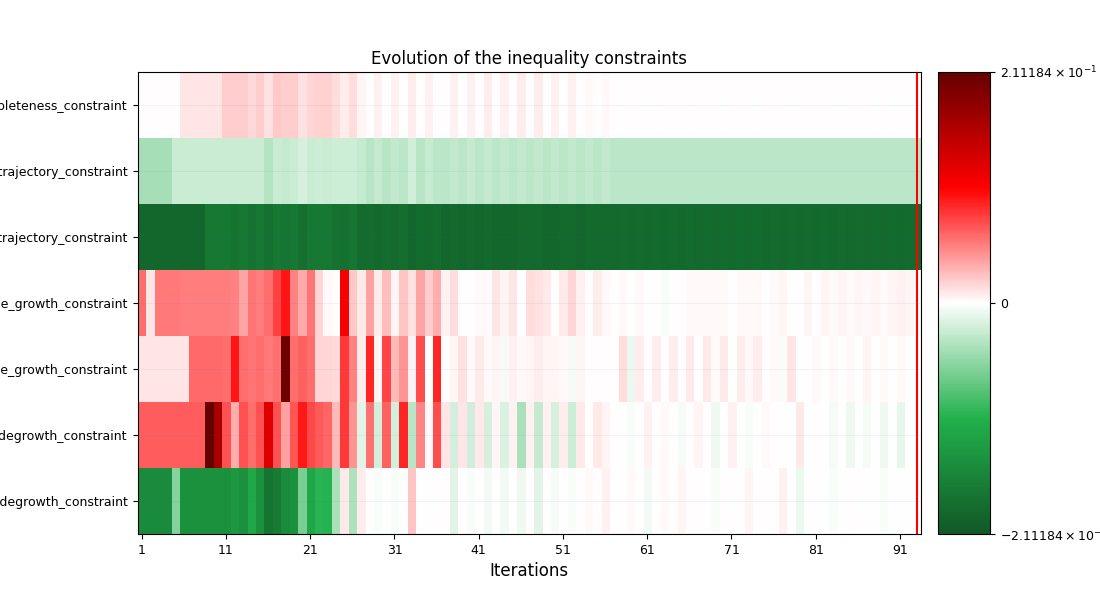

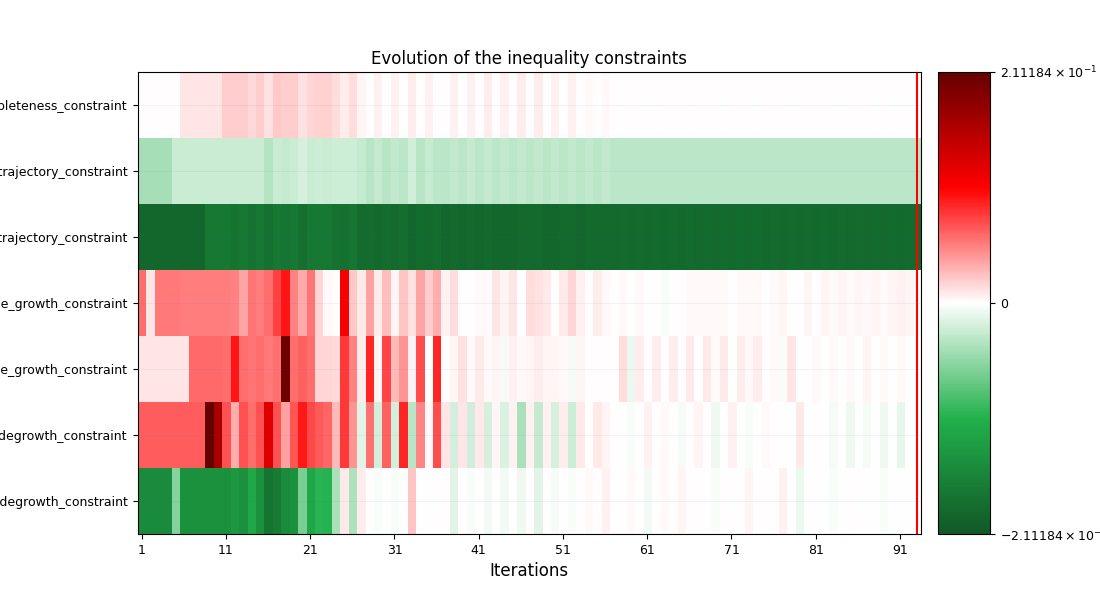

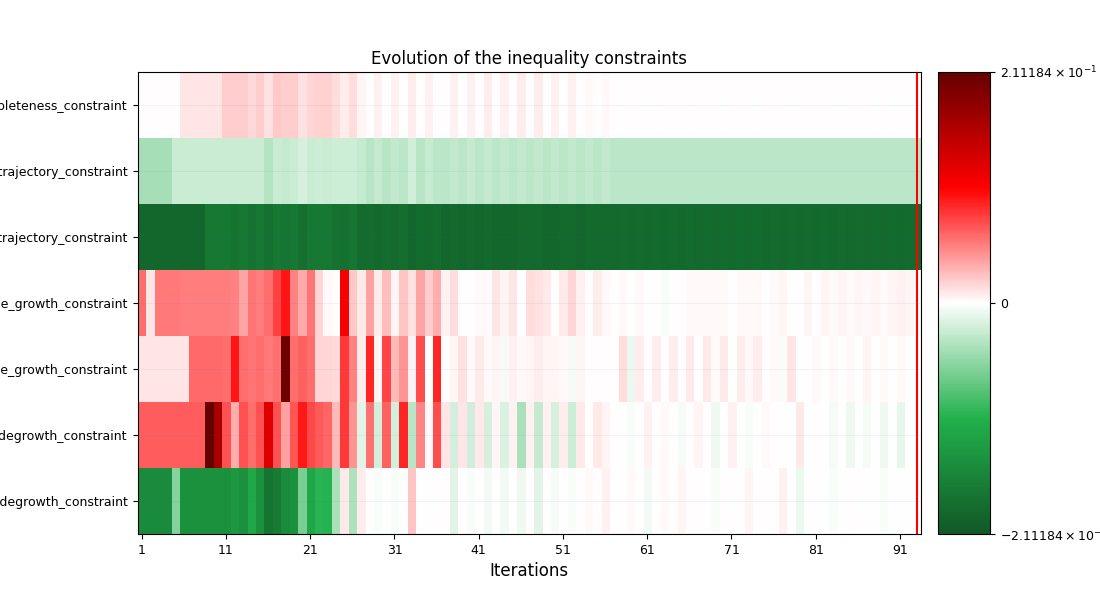

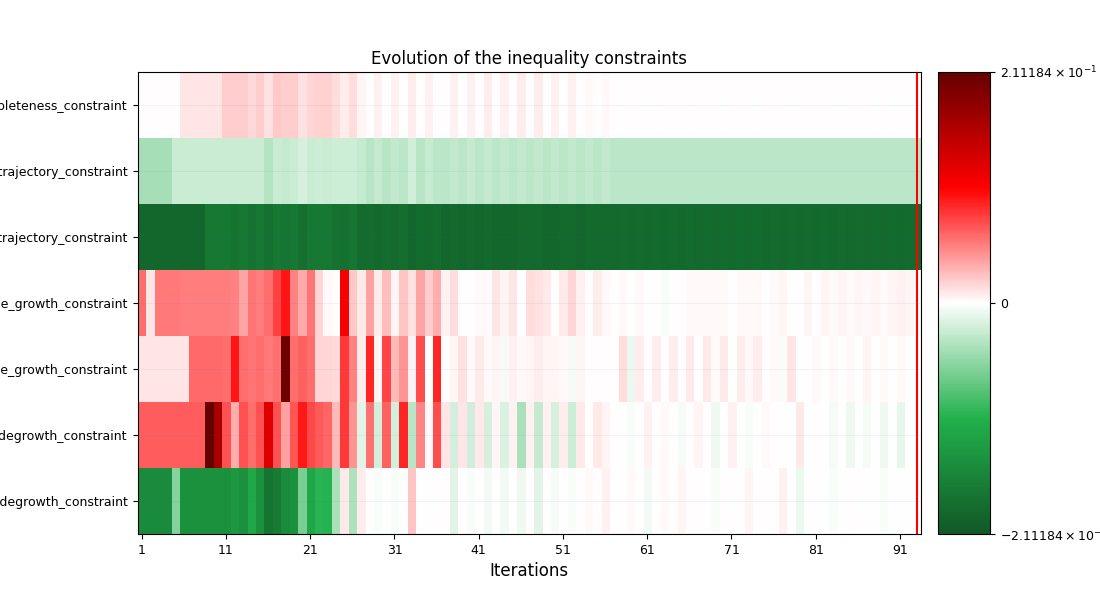

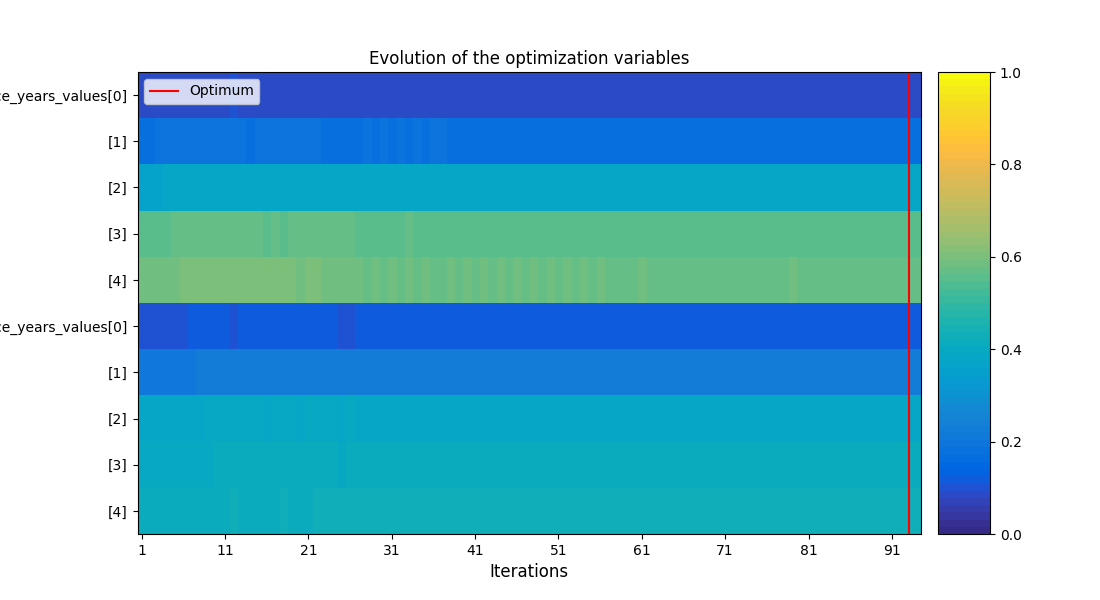

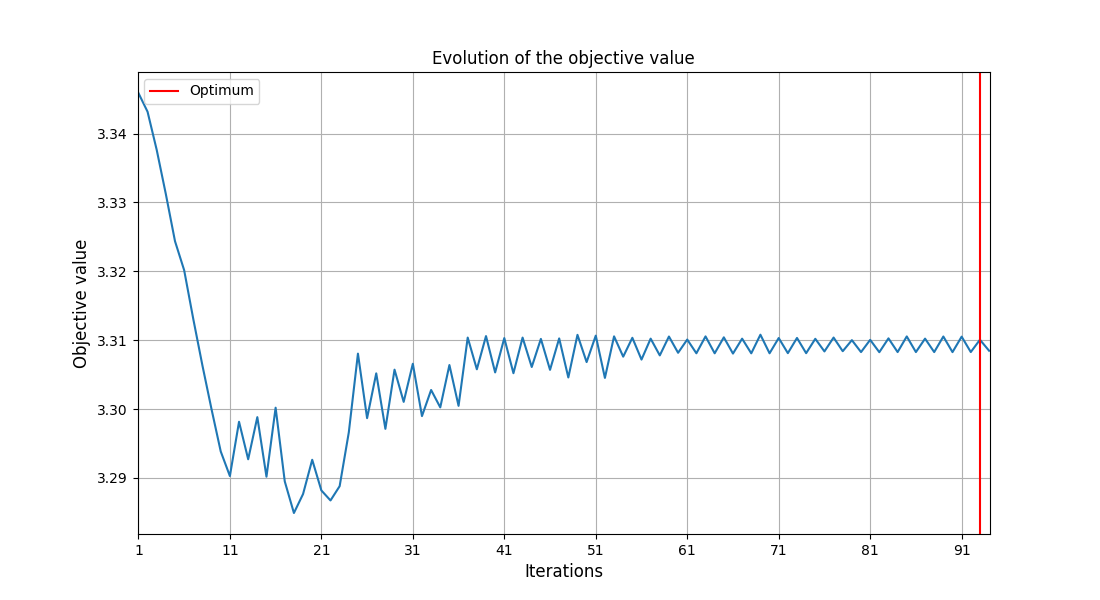

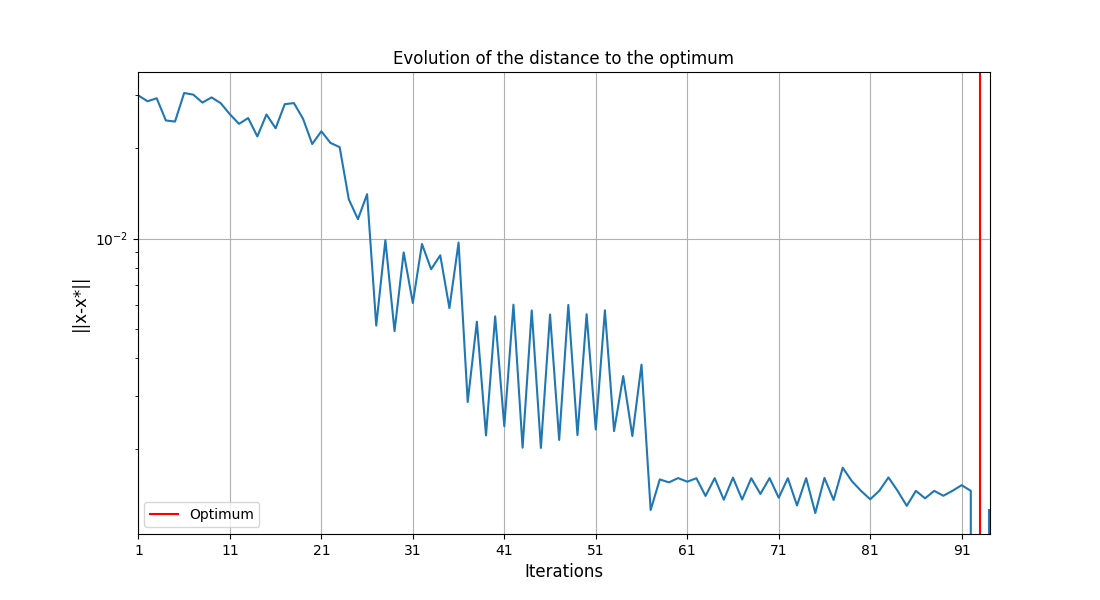

In [20]:
process.scenario.post_process("OptHistoryView", save=False, show=True)

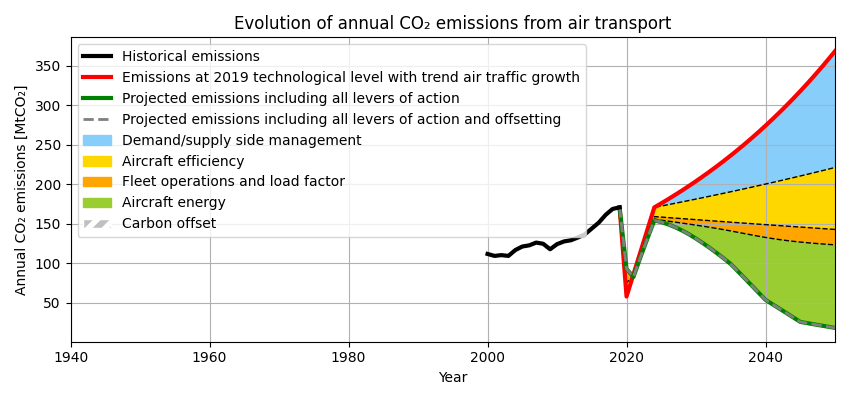

In [21]:
process.plot("air_transport_co2_emissions")

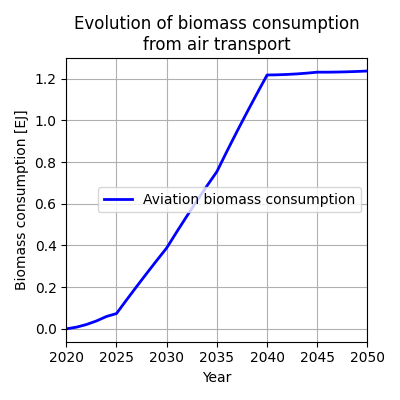

In [22]:
process.plot("biomass_consumption")

In [23]:
process.vector_outputs_df.loc[process.data['years']['prospective_years'], "electrofuel_share"],

(2019     0.000000
 2020     0.000000
 2021     0.000000
 2022     0.000000
 2023     0.000000
 2024     0.000000
 2025     0.000000
 2026     1.793249
 2027     3.586498
 2028     5.379747
 2029     7.172996
 2030     8.966245
 2031    10.912865
 2032    12.859486
 2033    14.806106
 2034    16.752727
 2035    18.699347
 2036    22.645433
 2037    26.591520
 2038    30.537606
 2039    34.483692
 2040    38.429779
 2041    41.918977
 2042    45.408175
 2043    48.897373
 2044    52.386571
 2045    55.875769
 2046    56.247924
 2047    56.620080
 2048    56.992236
 2049    57.364392
 2050    57.736548
 Name: electrofuel_share, dtype: float64,)

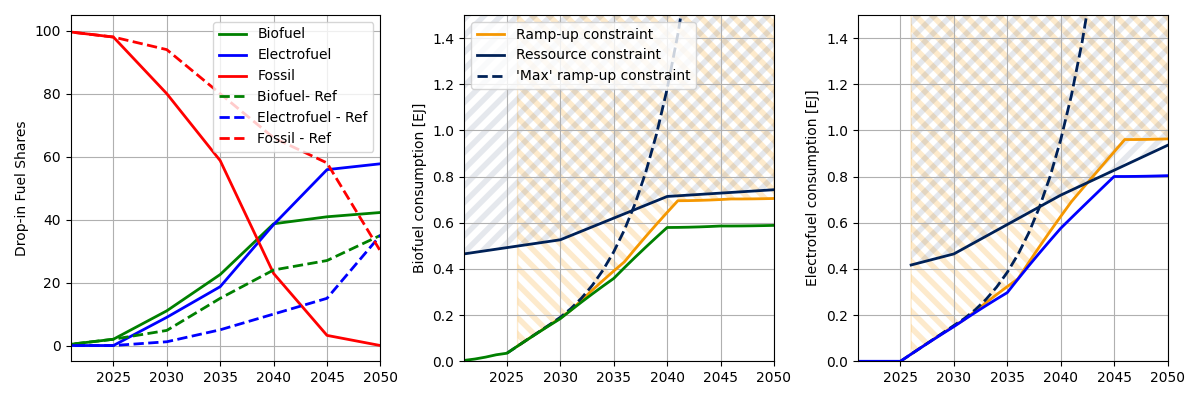

In [24]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,4))

ax1.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "biofuel_share"],
    color="green",
    linestyle="-",
    label="Biofuel",
    linewidth=2,
)

ax1.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "electrofuel_share"],
    color="blue",
    linestyle="-",
    label="Electrofuel",
    linewidth=2,
)

ax1.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "kerosene_share"],
    color="red",
    linestyle="-",
    label="Fossil",
    linewidth=2,
)


ax1.plot(
    [2020,2025,2030,2035,2040,2045,2050],
    [0, 2, 4.8, 15, 24, 27, 35],
    color="green",
    linestyle="--",
    label="Biofuel- Ref",
    linewidth=2,
)

ax1.plot(
    [2020,2025,2030,2035,2040,2045,2050],
    [0, 0, 1.2, 5, 10, 15, 35],
    color="blue",
    linestyle="--",
    label="Electrofuel - Ref",
    linewidth=2,
)

ax1.plot(
    [2020,2025,2030,2035,2040,2045,2050],
    [100, 98, 94.0, 80, 66, 58, 30],
    color="red",
    linestyle="--",
    label="Fossil - Ref",
    linewidth=2,
)


ax1.grid()
ax1.legend()
ax1.set_ylabel("Drop-in Fuel Shares")
ax1.set_xlim(2021,2050)




ax2.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "annual_biofuel_growth_constraint_viz"]/1e12,
    color="#F59700",
    linestyle="-",
    label="Ramp-up constraint",
    linewidth=2,
)

ax2.fill_between(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "annual_biofuel_growth_constraint_viz"]/1e12,
    3,   
    hatch='\\\\',  
    edgecolor="#F59700",
    facecolor='none',
    alpha=0.2
)



ax2.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "biofuel_max_availability_viz"]/1e12,
    color="#002157",
    linestyle="-",
    label="Ressource constraint",
    linewidth=2,
)

ax2.fill_between(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "biofuel_max_availability_viz"]/1e12,
    3,   
    hatch='//',  
    edgecolor="#002157",
    facecolor='none',
    linewidth=0,
    alpha=0.1
)


ax2.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "biofuel_growth_constraint_theoretical_max_viz"]/1e12,
    color="#002157",
    linestyle="--",
    label="'Max' ramp-up constraint",
    linewidth=2,
)


ax2.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "energy_consumption_biofuel"]/1e12,
    color="green",
    linestyle="-",
    # label="Aviation biofuel consumption",
    linewidth=2,
)



ax2.grid()
# ax2.set_xlabel("Year")
ax2.set_ylabel("Biofuel consumption [EJ]")
ax2.legend(loc='upper left')
ax2.set_xlim(2021,2050)
ax2.set_ylim(0,1.5)



ax3.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "annual_electrofuel_growth_constraint_viz"]/1e12,
    color="#F59700",
    linestyle="-",
    # label="Electrofuel ramp-up constraint",
    linewidth=2,
)

ax3.fill_between(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "annual_electrofuel_growth_constraint_viz"]/1e12,
    3,   
    hatch='\\\\',  
    edgecolor="#F59700",
    facecolor='none',
    alpha=0.2
)



ax3.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "electrofuel_max_availability_viz"]/1e12,
    color="#002157",
    linestyle="-",
    # label="Electricity availability constraint",
    linewidth=2,
)

ax3.fill_between(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "electrofuel_max_availability_viz"]/1e12,
    3,   
    hatch='//',  
    edgecolor="#002157",
    facecolor='none',
    linewidth=0,
    alpha=0.1
)


ax3.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "electrofuel_growth_constraint_theoretical_max_viz"]/1e12,
    color="#002157",
    linestyle="--",
    # label="Electrofuel theoretical max ramp-Up constraint",
    linewidth=2,
)


ax3.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "energy_consumption_electrofuel"]/1e12,
    color="blue",
    linestyle="-",
    # label="Aviation electrofuel consumption",
    linewidth=2,
)


ax3.grid()
ax3.set_ylabel("Electrofuel consumption [EJ]")
ax3.set_xlim(2021,2050)
ax3.set_ylim(0,1.5)

fig.tight_layout()
fig.savefig('ressource_constraints.png', dpi=800)


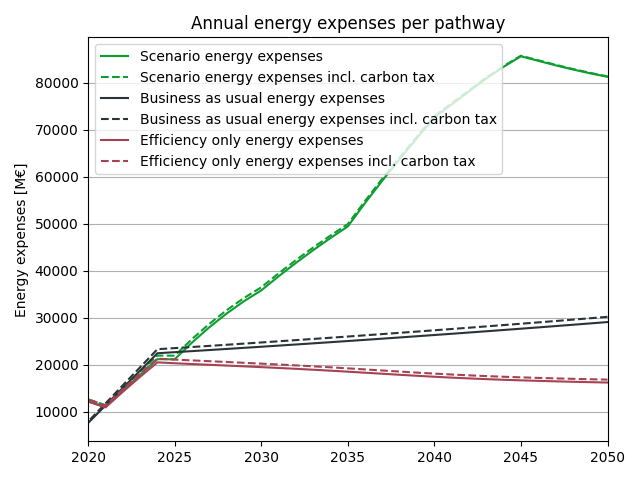

In [25]:
process.plot("energy_expenses_carbon_tax_effect")

In [26]:
process.vector_outputs_df["cumulative_co2_emissions"][2050]

2.6440987005524192

In [27]:
process.vector_outputs_df["co2_emissions_including_energy"][2050]


18.397151813770314

In [28]:
process.vector_outputs_df["cumulative_total_airline_cost_discounted"][2050]

4888079439771.0205

In [29]:
max(process.vector_outputs_df["electricity_consumption"].dropna())

1.8416536306748585

In [30]:
sum(process.vector_outputs_df["electricity_consumption"].dropna())

26.47140000845093

In [31]:
max(process.vector_outputs_df["biomass_consumption"].dropna())

1.2365150890640153

In [32]:
sum(process.vector_outputs_df["biomass_consumption"].dropna())

22.044890398325705

In [33]:
# from gemseo.algos.design_space import DesignSpace
# from gemseo import generate_n2_plot, create_scenario

# manual_DOE_carbon_budgets = [k * europe_ask_share for k in [2.0, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.2, 3.5, 4.0]]
# manual_DOE_results = {}

                    
# for carbon_budget_share in manual_DOE_carbon_budgets:
    
#     process.parameters.aviation_carbon_budget_objective = carbon_budget_share
                             
#     process.setup()

#     design_space = DesignSpace()

#     # design_space.add_variable("load_factor_end_year", size=1, lower_bound=89.0, upper_bound=89.5, value=89.2)
#     design_space.add_variable("electrofuel_share_reference_years_values", size=7, lower_bound=[0, 0, 0, 0, 0, 0, 0], upper_bound=[0, 100, 100,100, 100, 100, 100], value=[0, 0, 1.2, 5, 10, 15, 35])
#     design_space.add_variable("biofuel_share_reference_years_values", size=7, lower_bound=[0, 0, 0, 0, 0, 0, 0], upper_bound=[0, 100, 100,100, 100, 100, 100], value=[0, 2, 4.8, 15, 24, 27, 35])
#     # design_space.add_variable("biofuel_share_reference_years_values", size=7, lower_bound=np.array([0, 0, 0,0, 0, 0, 0]), upper_bound=np.array([0, 100, 100,100, 100, 100, 100]), value=np.array([0, 0, 1.2, 5, 10, 15, 35]))
#     # design_space.add_variable("biofuel_share_reference_years_values", size=1, lower_bound=1, upper_bound=100, value=5)

#     objective_name = "cumulative_total_airline_cost_discounted_obj"


#     process.gemseo_settings["design_space"] = design_space

#     process.gemseo_settings["objective_name"] = objective_name

#     # process.gemseo_settings["scenario_type"]="DOE"
#     process.gemseo_settings["scenario_type"] = "MDO"

#     # Create a GEMSEO scenario
#     process.create_gemseo_scenario()

#     # Set differention method (only use for gradient based optimizers)
#     process.scenario.set_differentiation_method("finite_differences")

#     # Add constraints
#     all_constraints = [
#         "aviation_carbon_budget_constraint",
#         "blend_completeness_constraint",
#         "electricity_trajectory_constraint",
#         "biomass_trajectory_constraint",
#         "electrofuel_use_growth_constraint",
#         "biofuel_use_growth_constraint",
#         "biofuel_use_no_degrowth_constraint",
#         "electrofuel_use_no_degrowth_constraint"
#     ]



#     for constraint in all_constraints:
#         process.scenario.add_constraint(constraint, constraint_type="ineq")



#     process.scenario.formulation.optimization_problem.objective = process.scenario.formulation.optimization_problem.objective * 1e-12

#     algo_options = {
#         "ftol_rel": 0.001,
#         "ftol_abs": 0.001,
#         "normalize_design_space": True,
#         "init_step":1
#     }
#     # Configure the algorithm used
#     # config_algo = {"algo": "NLOPT_COBYLA", "max_iter": 200}
#     config_algo = {
#         "algo": "NLOPT_COBYLA",
#         "max_iter": 500,
#         "algo_options":algo_options
#     }
#     # config_algo = {"algo": "DIFFERENTIAL_EVOLUTION", "max_iter": 1000}

#     #Configure the DOE used

#     # config_algo = {"algo": "LHS", "n_samples": 1000}


#     process.input_data.update(config_algo)
                             
#     process.compute()
    
#     manual_DOE_results[carbon_budget_share]=process.scenario.get_result().optimization_problems_to_results
                             
    

In [34]:
# manual_DOE_results

In [35]:
# {
#   "0.3098": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 0.0200054873, 2.05140066, 21.1813998, 50.2237717, 62.708779, 67.6659455, 0.0, 6.37460003, 13.3005508, 23.9880299, 34.5420461, 38.6414905, 40.5526613],
#         "Objective function": 4.923723348357994,
#         "Feasible solution": false
#       }
#     }
#   },
#   "0.38725000000000004": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 9.50830997e-16, 5.46074505e-15, 4.87835124, 17.8344375, 35.9188935, 44.7192748, 0.0, 6.06082219, 13.16114, 23.2813313, 30.8878381, 35.5180169, 37.1535953],
#         "Objective function": 4.703385363758759,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.40274000000000004": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 5.68528514e-16, 3.52478468e-16, 2.13553207, 11.523514, 27.3651544, 48.9386831, 0.0, 5.57028651, 13.8559199, 14.8875224, 26.9343106, 35.2600772, 37.1299377],
#         "Objective function": 4.65427847765963,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.41823000000000005": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 8.00602614e-15, 0.493206033, 2.15320295, 6.84688915, 16.065036, 35.8409102, 0.0, 5.21639236, 9.54168243, 15.385152, 30.3210818, 35.4914538, 36.6780568],
#         "Objective function": 4.608114408167807,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.43372": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 2.60208521e-15, 2.01227923e-14, 1.90819582e-14, 4.46973153, 14.5540439, 32.7356765, 0.0, 3.12017252, 8.47822827, 13.5795412, 23.1990379, 29.6078295, 34.8518127],
#         "Objective function": 4.569699143108438,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.44921": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 0.11924028, 0.4731823, 3.9455404, 17.04417396, 40.53708351, 56.24505107, 0.0, 0.08376552, 0.67126784, 8.39397436, 15.21908486, 28.46091729, 36.36557437],
#         "Objective function": 4.659503862073434,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.4647": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 5.0497717e-16, 1.71911138e-15, 7.20866319e-15, 5.34337113e-14, 2.77555756e-14, 1.61869054, 0.0, 9.96287534e-15, 2.65478792, 10.1524168, 20.8683498, 32.3839377, 37.0775387],
#         "Objective function": 4.4858105558686425,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.49568000000000006": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 1.209974e-15, 9.07712291e-17, 4.52762243e-17, 0.501961593, 13.5764353, 29.1746387, 0.0, 1.50004538, 10.175401, 20.0427433, 27.2900464, 35.5768404, 37.155043],
#         "Objective function": 4.570591342503452,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.54215": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 1.63064007e-14, 1.83880688e-14, 1.11022302e-14, 6.1409211e-14, 8.46564825, 53.1968294, 0.0, 8.32667268e-15, 6.28789295, 12.7622453, 20.8460642, 30.18929, 31.6952819],
#         "Objective function": 4.555169656402445,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.6196": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 1.63064007e-14, 1.83880688e-14, 1.11022302e-14, 6.1409211e-14, 8.46564825, 53.1968294, 0.0, 8.32667268e-15, 6.28789295, 12.7622453, 20.8460642, 30.18929, 31.6952819],
#         "Objective function": 4.555169656402445,
#         "Feasible solution": true
#       }
#     }
#   }
# }
